In [134]:
import glob
import pytz
import datetime
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
import matplotlib.pyplot as plt

In [135]:
all_files = glob.glob('data/traffic_data/*.csv')
traffic_data = pd.concat((pd.read_csv(f) for f in all_files))

In [136]:
traffic_data.head()

,human_count,timestamp
0,0,2020-10-16 17:07:19
1,0,2020-10-16 17:07:48
2,1,2020-10-16 17:08:18
3,0,2020-10-16 17:08:48
4,0,2020-10-16 17:09:17


In [137]:
traffic_data.describe()

,human_count
count,164646.000000
mean,0.596941
std,1.212947
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,14.000000


In [138]:
traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'])

(array([18543., 18550., 18557., 18567., 18574., 18581., 18588., 18597.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

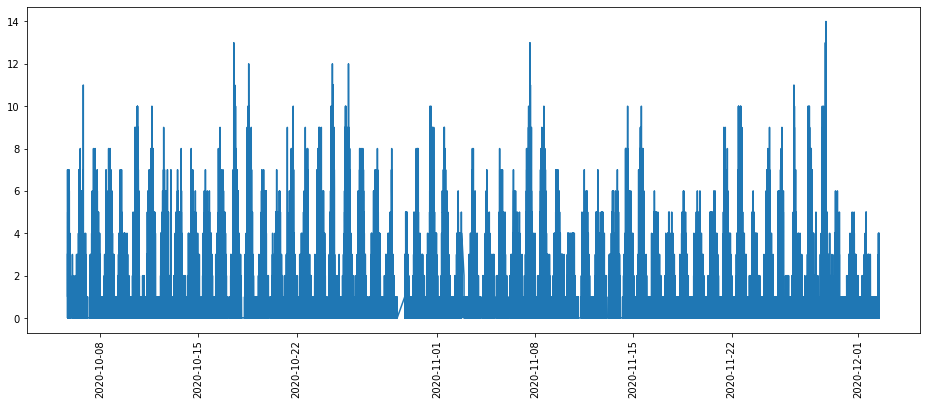

In [139]:
plt.figure(figsize=(16, 6))
traffic_data = traffic_data.sort_values('timestamp', ascending=True)
plt.plot(traffic_data['timestamp'], traffic_data['human_count'])
plt.xticks(rotation='vertical')

In [140]:
# add datetime related features
traffic_data['date'] = traffic_data['timestamp'].dt.date
traffic_data['day_of_week'] = traffic_data['timestamp'].apply(lambda x: x.weekday())
traffic_data['hour'] = traffic_data['timestamp'].apply(lambda x: x.hour)
traffic_data

,human_count,timestamp,date,day_of_week,hour
0,3,2020-10-05 16:16:17,2020-10-05,0,16
1,2,2020-10-05 16:16:47,2020-10-05,0,16
2,5,2020-10-05 16:17:16,2020-10-05,0,16
3,2,2020-10-05 16:17:46,2020-10-05,0,16
4,1,2020-10-05 16:18:15,2020-10-05,0,16
...,...,...,...,...,...
116,1,2020-12-02 12:07:44,2020-12-02,2,12
117,0,2020-12-02 12:08:14,2020-12-02,2,12
118,1,2020-12-02 12:08:44,2020-12-02,2,12
119,2,2020-12-02 12:09:14,2020-12-02,2,12


In [141]:
# add feature for if the sun is up
def sun_is_up(date, hour):
    city = LocationInfo('Atlanta', 'Georgia', 'America/New_York', 33.7490, -84.3880)
    s = sun(city.observer, date=date, tzinfo=city.timezone)
    return s['sunrise'] < datetime.datetime(date.year, date.month, date.day, hour, 0, 0, tzinfo=pytz.timezone(city.timezone)) < s['sunset']
traffic_data['sun_is_up'] = traffic_data.apply(lambda x: int(sun_is_up(x.date, x.hour)), axis=1)

In [142]:
# add feature for precipitation
weather_data = pd.read_csv('data/weather.csv')
weather_data = weather_data.query('STATION == "US1GAFT0057"')
weather_data['PRCP'] = weather_data.apply(lambda x: x.PRCP if x.PRCP is not None else x.MDPR, axis=1)
weather_data['DATE'] = pd.to_datetime(weather_data['DATE']).dt.date
weather_data = weather_data[['DATE', 'PRCP']]
weather_data.columns = ['date', 'daily_precipitation']
traffic_data = pd.merge(traffic_data, weather_data, how='left', on=['date'])

Counts of each value:


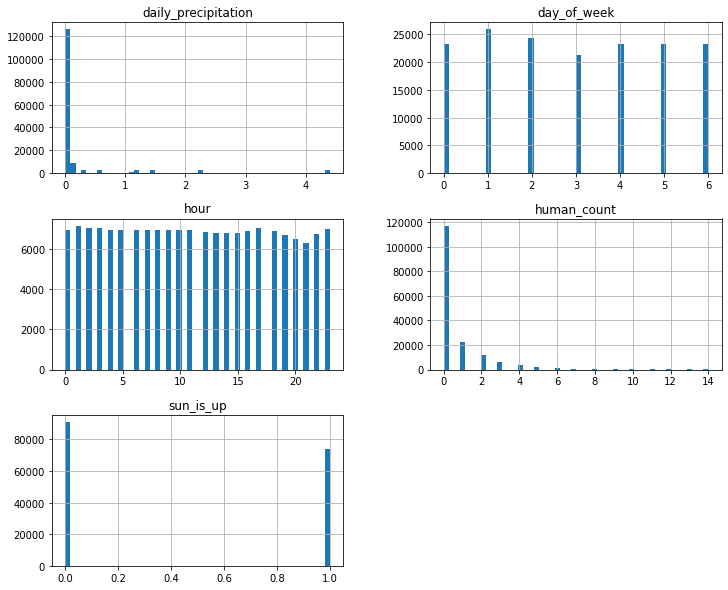

In [143]:
traffic_data.hist(bins=50, figsize=(12,10))
print('Counts of each value:')
plt.show()

In [144]:
# aggregate by hour
traffic_data = traffic_data.groupby(['date', 'hour', 'day_of_week', 'sun_is_up', 'daily_precipitation'])[['human_count']].agg('sum')
traffic_data

human_count
date       hour day_of_week sun_is_up daily_precipitation             
2020-10-05 16   0           1         0.0                          194
           17   0           1         0.0                          122
           18   0           1         0.0                           20
           19   0           0         0.0                          136
           20   0           0         0.0                           75
...                                                                ...
2020-12-02 8    2           1         0.0                            1
           9    2           1         0.0                            8
           10   2           1         0.0                           69
           11   2           1         0.0                           92
           12   2           1         0.0                           14

[1272 rows x 1 columns]

human_count over all hours:


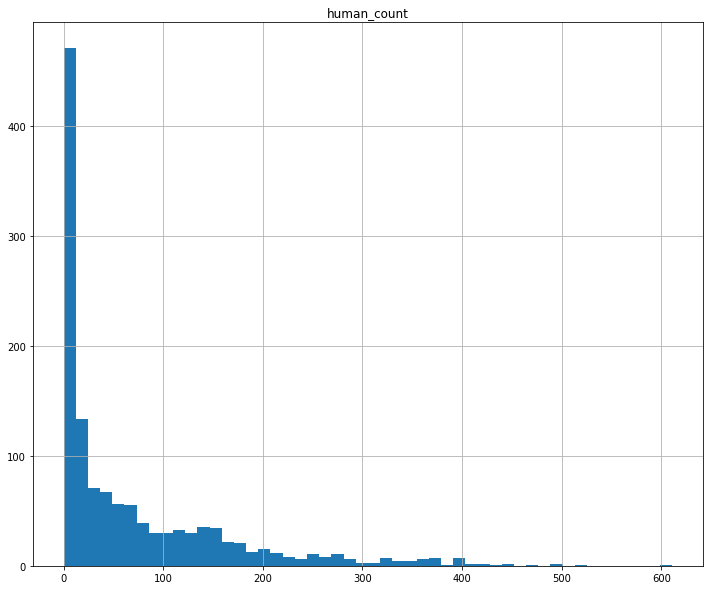

In [145]:
traffic_data.hist(bins=50, figsize=(12,10))
print('human_count over all hours:')
plt.show()